BERT

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid-19-nlp-text-classification


In [ ]:
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import os # Import the os module
import kagglehub # Import kagglehub
from sklearn.metrics import accuracy_score # Import accuracy_score

# Ensure the required nltk data is downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Step 1: Data preprocessing - Clean the text and focus on sentiment words
def clean_and_focus_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())  # Remove non-alphabetic characters
    tokens = text.split()

    # Focus on important sentiment-related words (positive/negative keywords)
    sentiment_keywords = ['positive', 'negative', 'good', 'bad', 'love', 'hate', 'happy', 'sad', 'joy', 'angry']
    filtered_tokens = [token for token in tokens if token not in stop_words and token in sentiment_keywords]
    return ' '.join(filtered_tokens)

dataset_path = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")
train_file_path = os.path.join(dataset_path, 'Corona_NLP_train.csv')
df = pd.read_csv(train_file_path, encoding='latin1')

# Apply the cleaning function
df['clean_text'] = df['OriginalTweet'].apply(clean_and_focus_text)


# Convert Sentiment into numerical labels (Positive = 2, Neutral = 1, Negative = 0)
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Extremely Negative': 0, 'Extremely Positive': 2}
df['label'] = df['Sentiment'].map(label_map)

# Step 2: Tokenization and Encoding using BERT Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize and pad the sequences
train_texts, val_texts, train_labels, val_labels = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

# Step 3: Dataset Class for BERT Input
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
val_dataset = TweetDataset(val_encodings, val_labels.tolist())

# Step 4: Load BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# Step 5: Training Arguments Setup
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch", # Set save_strategy to "epoch"
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Step 6: Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Step 7: Trainer and Training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics # Pass the compute_metrics function
)

# Step 8: Train the Model
trainer.train()

# Step 9: Evaluate the model
trainer.evaluate()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.986700,1.045548,0.439383


{'eval_loss': 1.0455479621887207,
 'eval_accuracy': 0.4393828960155491,
 'eval_runtime': 6.8116,
 'eval_samples_per_second': 1208.528,
 'eval_steps_per_second': 75.606,
 'epoch': 1.0}

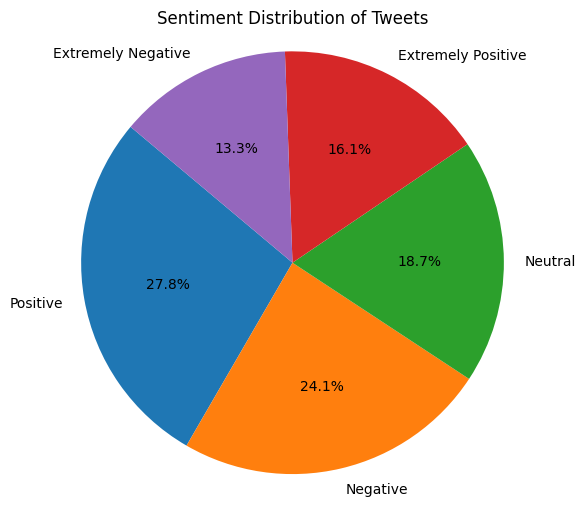

In [ ]:
# prompt: give me a chart

from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import collections
import nltk
from sklearn.metrics import accuracy_score
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Load the dataset
dataset_path = '/kaggle/input/covid-19-nlp-text-classification'
train_file_path = os.path.join(dataset_path, 'Corona_NLP_train.csv')
df = pd.read_csv(train_file_path, encoding='latin1')

# Step 2: Visualize Sentiment Distribution (Pie Chart)
sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Sentiment Distribution of Tweets")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()